# 1.) Introduction

Hello, and welcome to our Final Project for Big Data Analytics (CIS 5450).

Our project involves not only investigating the correlation between demographics and heart disease mortality rates, but also predicting these rates 
as both continuous and discrete variables (above or below average) separately. The dataset consists of two files: (1) one containing demographic data such as age, gender, race, education level, and income at the zipcode level, and (2) another containing heart disease mortality rates at the same level. We merge these two datasets using zipcodes as a common identifier. Our analysis includes visualizations and statistical modeling techniques, such as Logistic Regressions (with and without PCA), Linear Regressions (with and without L1 Regularization), and Random Forest.


Project Contributors: 
* Octavio de Lima
* Steven Philbrook
* Nick Mariano

## 1.1.) Packages and Libraries Setup

This first section is used to download all the necessary Packages and Libraries that we will be using throughout the rest of the notebook.

In [ ]:
## Install Required Packages, quietly
! pip install -q geopandas
! pip install -q uszipcode
! pip install -q mapclassify
! pip install -q python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 93.5 MB/s eta 0:00:00


In [ ]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
#####################################################################################
# SETUP - Import Required Libraries
#####################################################################################

import tqdm
import zipfile
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import geopandas as gpd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import mapclassify
from geopy.geocoders import Nominatim
import numpy as np
from uszipcode import SearchEngine
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso
from uszipcode import SearchEngine
os.chdir('drive/MyDrive/5450-Group-Project-Folder/0code')
np.set_printoptions(suppress=True, formatter={'float_kind':'{:f}'.format})

## 1.2.) Zip Code Dataframe Setup
Here, we will download the dataset containing population and demographic features for various zip codes in the United States.

In [ ]:
############################################################################################################
# Get zip code level data using the uszipcode module (avg runtime ~2min)
############################################################################################################

import gc
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 250)

# Create a SearchEngine object
search = SearchEngine(simple_or_comprehensive=SearchEngine.SimpleOrComprehensiveArgEnum.comprehensive)

# Search for zipcodes in a given state
result = search.by_median_home_value(lower=-1, returns = 50000)

data = []
for zipcode in result:
    data.append({   'zipcode': zipcode.zipcode, 
                    'lat': zipcode.lat, 
                    'lng': zipcode.lng, 
                    'county': zipcode.county,
                    'population': zipcode.population,
                    'population_by_age': zipcode.population_by_age,
                    'population_by_gender': zipcode.population_by_gender,
                    'population_by_race': zipcode.population_by_race,
                    'population_density': zipcode.population_density,
                    'median_household_income': zipcode.median_household_income,
                    'household_income': zipcode.household_income,
                    'education': zipcode.educational_attainment_for_population_25_and_over,
                    'employment_status': zipcode.employment_status,
                    'housing_occupancy': zipcode.housing_occupancy,
                    'family_type': zipcode.families_vs_singles
                    })
df = pd.DataFrame(data)

del result
gc.collect()

############################################################################################################
# Create pop_by_gender_male and pop_by_gender_female based on the population_by_gender JSON-formatted column
############################################################################################################


def get_pop_by_gender(row):
    pop_by_gender_dict = {}
    for item in row:
        for value in item['values']:
            pop_by_gender_dict[f"pop_by_gender_{value['x'].lower()}"] = pop_by_gender_dict.get(f"pop_by_gender_{value['x'].lower()}", 0) + value['y']
    return pop_by_gender_dict
df = pd.concat([df.drop('population_by_gender', axis=1), df['population_by_gender'].apply(get_pop_by_gender).apply(pd.Series)], axis=1)


############################################################################################################
# Create pop_by_race_white and pop_by_race_black [...] based on the population_by_race JSON-formatted column
############################################################################################################


def get_pop_by_race(row):
    pop_by_race_dict = {}
    for item in row:
        for value in item['values']:
            pop_by_race_dict[f"pop_by_race_{value['x'].lower()}"] = pop_by_race_dict.get(f"pop_by_race_{value['x'].lower()}", 0) + value['y']
    return pop_by_race_dict
df = pd.concat([df.drop('population_by_race', axis=1), df['population_by_race'].apply(get_pop_by_race).apply(pd.Series)], axis=1)


############################################################################################################
# Create pop_by_age_under_5, pop_by_age_5_to_9 [...] based on the population_by_age JSON-formatted column
############################################################################################################


def get_pop_by_age(row):
    column_names = ['under_5', '5_to_9', '10_to_14', '15_to_19', '20_to_24', '25_to_29', '30_to_34',
                    '35_to_39', '40_to_44', '45_to_49', '50_to_54', '55_to_59', '60_to_64', '65_to_69',
                    '70_to_74', '75_to_79', '80_to_84', '85_and_over']
    pop_by_age_dict = {f'pop_by_age_{name}': 0 for name in column_names}
    for item in row:
        if item['key'] == "Total":
            for value in item['values']:
                age_group = int(value['x'])
                if age_group < len(column_names):
                    pop_by_age_dict.setdefault(f"pop_by_age_{column_names[age_group]}", 0)
                    pop_by_age_dict[f"pop_by_age_{column_names[age_group]}"] += value['y']
    return pop_by_age_dict
df = pd.concat([df.drop('population_by_age', axis=1), df['population_by_age'].apply(get_pop_by_age).apply(pd.Series)], axis=1)


############################################################################################################
# Create household_income columns based on the household_income JSON-formatted column
############################################################################################################


def get_household_income(row):
    household_income_dict = {}
    for item in row:
        for value in item['values']:
            household_key = f"household_income_{value['x'].lower().replace(' ', '_')}"
            household_income_dict[household_key] = household_income_dict.get(household_key, 0) + value['y']
    return household_income_dict
df = pd.concat([df.drop('household_income', axis=1), df['household_income'].apply(get_household_income).apply(pd.Series)], axis=1)


############################################################################################################
# Create education columns based on the education JSON-formatted column
############################################################################################################


def get_education(row):
    education_dict = {}
    for item in row:
        for value in item['values']:
            education_key = f"education_{value['x'].lower().replace(' ', '_')}"
            education_dict[education_key] = education_dict.get(education_key, 0) + value['y']
    return education_dict
df = pd.concat([df.drop('education', axis=1), df['education'].apply(get_education).apply(pd.Series)], axis=1)


############################################################################################################
# Create employment_status columns based on the employment_status JSON-formatted column
############################################################################################################


def get_employment_status(row):
    employment_status_dict = {}
    for item in row:
        for value in item['values']:
            employment_status_key = f"employment_status_{value['x'].lower().replace(' ', '_')}"
            employment_status_dict[employment_status_key] = employment_status_dict.get(employment_status_key, 0) + value['y']
    return employment_status_dict
df = pd.concat([df.drop('employment_status', axis=1), df['employment_status'].apply(get_employment_status).apply(pd.Series)], axis=1)


############################################################################################################
# Create housing_occupancy columns based on the housing_occupancy JSON-formatted column
############################################################################################################


def get_housing_occupancy(row):
    housing_occupancy_dict = {}
    for item in row:
        for value in item['values']:
            housing_occupancy_key = f"housing_occupancy_{value['x'].lower().replace(' ', '_')}"
            housing_occupancy_dict[housing_occupancy_key] = housing_occupancy_dict.get(housing_occupancy_key, 0) + value['y']
    return housing_occupancy_dict
df = pd.concat([df.drop('housing_occupancy', axis=1), df['housing_occupancy'].apply(get_housing_occupancy).apply(pd.Series)], axis=1)


############################################################################################################
# Create family_type columns based on the family_type JSON-formatted column
############################################################################################################


def get_family_type(row):
    family_type_dict = {}
    for item in row:
        for value in item['values']:
            family_type_key = f"family_type_{value['x'].lower().replace(' ', '_')}"
            family_type_dict[family_type_key] = family_type_dict.get(family_type_key, 0) + value['y']
    return family_type_dict
df = pd.concat([df.drop('family_type', axis=1), df['family_type'].apply(get_family_type).apply(pd.Series)], axis=1)


############################################################################################################
# Check output
############################################################################################################

df.tail(3)

Download /root/.uszipcode/comprehensive_db.sqlite from https://github.com/MacHu-GWU/uszipcode-project/releases/download/1.0.1.db/comprehensive_db.sqlite ...
  50.00 MB downloaded ...
  100.00 MB downloaded ...
  150.00 MB downloaded ...
  200.00 MB downloaded ...
  250.00 MB downloaded ...
  300.00 MB downloaded ...
  350.00 MB downloaded ...
  400.00 MB downloaded ...
  Complete!


zipcode    lat     lng            county  population  population_density  median_household_income  pop_by_gender_male  pop_by_gender_female  pop_by_race_white  pop_by_race_black or african american  \
28640   71425  31.89  -91.88  Catahoula Parish         214                 6.0                    41250                 110                   104                208                                      6   
28641   83227  44.16 -114.49     Custer County         142                 0.0                    95964                  80                    62                140                                      0   
28642   97840  44.99 -116.87      Baker County          98                 1.0                    97656                  54                    44                 90                                      0   

       pop_by_race_american indian or alaskan native  pop_by_race_asian  pop_by_race_native hawaiian & other pacific islander  pop_by_race_other race  pop_by_race_two or more races  pop_by_age_under_5  pop_by_age_5_to_9  pop_by_age_10_to_14  \
28640                                              0                  0                                                  0                          0                              0                   8                 13                   12   
28641                                              0                  0                                                  1                          1                              0                   3                  0                    4   
28642                                              1                  0                                                  0                          0                              7                   6                  6                    4   

       pop_by_age_15_to_19  pop_by_age_20_to_24  pop_by_age_25_to_29  pop_by_age_30_to_34  pop_by_age_35_to_39  pop_by_age_40_to_44  pop_by_age_45_to_49  pop_by_age_50_to_54  pop_by_age_55_to_59  pop_by_age_60_to_64  pop_by_age_65_to_69  \
28640                   15                    3                    7                   17                   15                   12                   10                   18                   23                   17                   20   
28641                    4                    2                    6                    2                    5                   10                   19                   16                   17                   20                   10   
28642                    7                    3                    9                    3                    8                    5                    7                    9                   20                    5                    4   

       pop_by_age_70_to_74  pop_by_age_75_to_79  pop_by_age_80_to_84  pop_by_age_85_and_over  household_income_<_$25,000  household_income_$25,000-$44,999  household_income_$45,000-$59,999  household_income_$60,000-$99,999  \
28640                   10                    7                    3                       4                          53                                40                                43                                 0   
28641                   14                    6                    3                       1                           7                                31                                 0                                35   
28642                    1                    0                    0                       1                          10                                13                                 0                                27   

       household_income_$100,000-$149,999  household_income_$150,000-$199,999  household_income_$200,000+  education_less_than_high_school_diploma  education_high_school_graduate  education_associate's_degree  education_bachelor's_degree  \
28640                                   0                                   0                

## 1.3.) Heart Dataframe Setup
Below, we will get the Heart Disease Mortality Rate data and convert the given latitude and longitude of each observation to a zip code which we can use in our future analysis.

Dataset url: https://healthdata.gov/dataset/Heart-Disease-Mortality-Data-Among-US-Adults-35-by/gn3q-7tdm

Dataset Description: "2017 to 2019, 3-year average. Rates are age-standardized. County rates are spatially smoothed. The data can be viewed by gender and race/ethnicity. Data source: National Vital Statistics System. Additional data, maps, and methodology can be viewed on the Interactive Atlas of Heart Disease and Stroke."

In [ ]:
############################################################################################################
# Get Heart Disease Mortality Rate data (avg runtime ~2min)
############################################################################################################

# zip_codes = gpd.read_file('../2shapefiles/us_zip_codes.shp')
heart = pd.read_csv("../1data/Heart_Disease_Mortality_Data_Among_US_Adults__35___by_State_Territory_and_County___2017-2019.csv")

In [ ]:
############################################################################################################
# Convert Latitude and Longitude to new Zip Code column (avg runtime ~7min)
############################################################################################################

def get_zipcode(lat, lon):
    search = SearchEngine()
    try:
        result = search.by_coordinates(lat, lon, returns=1)
        if result:
            return result[0].zipcode
        else:
            return np.nan
    finally:
        search.close()

heart['zip_code'] = heart.apply(lambda x: get_zipcode(x['Y_lat'], x['X_lon']), axis=1)

Download /root/.uszipcode/simple_db.sqlite from https://github.com/MacHu-GWU/uszipcode-project/releases/download/1.0.1.db/simple_db.sqlite ...
  1.00 MB downloaded ...
  2.00 MB downloaded ...
  3.00 MB downloaded ...
  4.00 MB downloaded ...
  5.00 MB downloaded ...
  6.00 MB downloaded ...
  7.00 MB downloaded ...
  8.00 MB downloaded ...
  9.00 MB downloaded ...
  10.00 MB downloaded ...
  11.00 MB downloaded ...
  Complete!


# 2.) Exploratory Data Analysis

This section is dedicated to reviewing the data and trying to find any interactions between the various datasets we'll be using for the remainder of the project.

## 2.1.) Explore Zip Code Data
In this section, we will explore the data we derived from the uszipcode module. This data will be used for our model features.

First, we'll look at some key stats from the zipcode dataset.

In [ ]:
###################################################
## Create a table to view some key stats
###################################################

n_obs                     = len(df)
n_zipcodes                = len(df['zipcode'].unique())
med_income                = df['median_household_income'].median()
med_population            = df['population'].median()
med_pop_density           = df['population_density'].median()
med_renters               = (df['housing_occupancy_renter_occupied_households'] / df['population']).median() * 100
med_homeowners_mortgage   = (df['housing_occupancy_owned_households_with_a_mortgage'] / df['population']).median() * 100
med_homeowners_free_clear = (df['housing_occupancy_owned_households_free_&_clear'] / df['population']).median() * 100
med_homeowners_vacant     = (df['housing_occupancy_households_vacant'] / df['population']).median() * 100
med_white_pop             = (df['pop_by_race_white'] / df['population']).median() * 100
med_black_pop             = (df['pop_by_race_black or african american'] / df['population']).median() * 100
med_pop_65plus            = (df['pop_by_age_85_and_over'] / df['population']).median() * 100

# Create the table
data = {'Statistics': ['Total Number of Observations', 
                       'Number of Unique Zip Codes', 
                       'Median Number of Residents',
                       'Median Population Density',
                       'Median Household Income ($)',
                       'Median Share of Renters (%)', 
                       'Median Share of Homeowners with a Mortgage (%)', 
                       'Median Share of Homeowners Free and Clear (%)',
                       'Median Share of Homeowners Vacant (%)', 
                       'Median Share of Whites (%)',
                       'Median Share of Blacks (%)', 
                       'Median Share of Residents over 85 (%)'],
        
        'Values': [n_obs, 
                   n_zipcodes, 
                   med_population,
                   med_pop_density,
                   med_income, 
                   med_renters, 
                   med_homeowners_mortgage, 
                   med_homeowners_free_clear, 
                   med_homeowners_vacant,
                   med_white_pop, 
                   med_black_pop, 
                   med_pop_65plus]}
                   
table = pd.DataFrame(data=data)

# Style the table
table_style = table.style.set_properties(**{'text-align': 'left', 'border': '1px solid black',
                                             'font-size': '12pt', 'padding': '5px'}).set_table_styles(
                                                 [{    'selector': 'th',    'props': [(
                                                     'background-color', '#f2f2f2'), (
                                                         'border', '1px solid black'), (
                                                             'text-align', 'left'),
                                                              ('padding', '5px')] }, {
    'selector': 'td',
    'props': [('border', '1px solid black'), ('text-align', 'left'), ('padding', '5px')]
}]).format({'Values': '{:.1f}'}).set_caption('Summary Statistics, Zip Code Data')

# Print the styled table
display(table_style)

Next, we'll plot a correlation matrix containing all the features available in the zipcode dataset.

As you can see in the below correlation matrix, there is a significant amount of correlation between our features. We will address this in our models (by leveraging tools like PCA and regularization).

<ipython-input-44-640409e8d7db>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = sns.heatmap(df.corr(), cmap="Blues", vmin=-1, vmax=1, center=0,


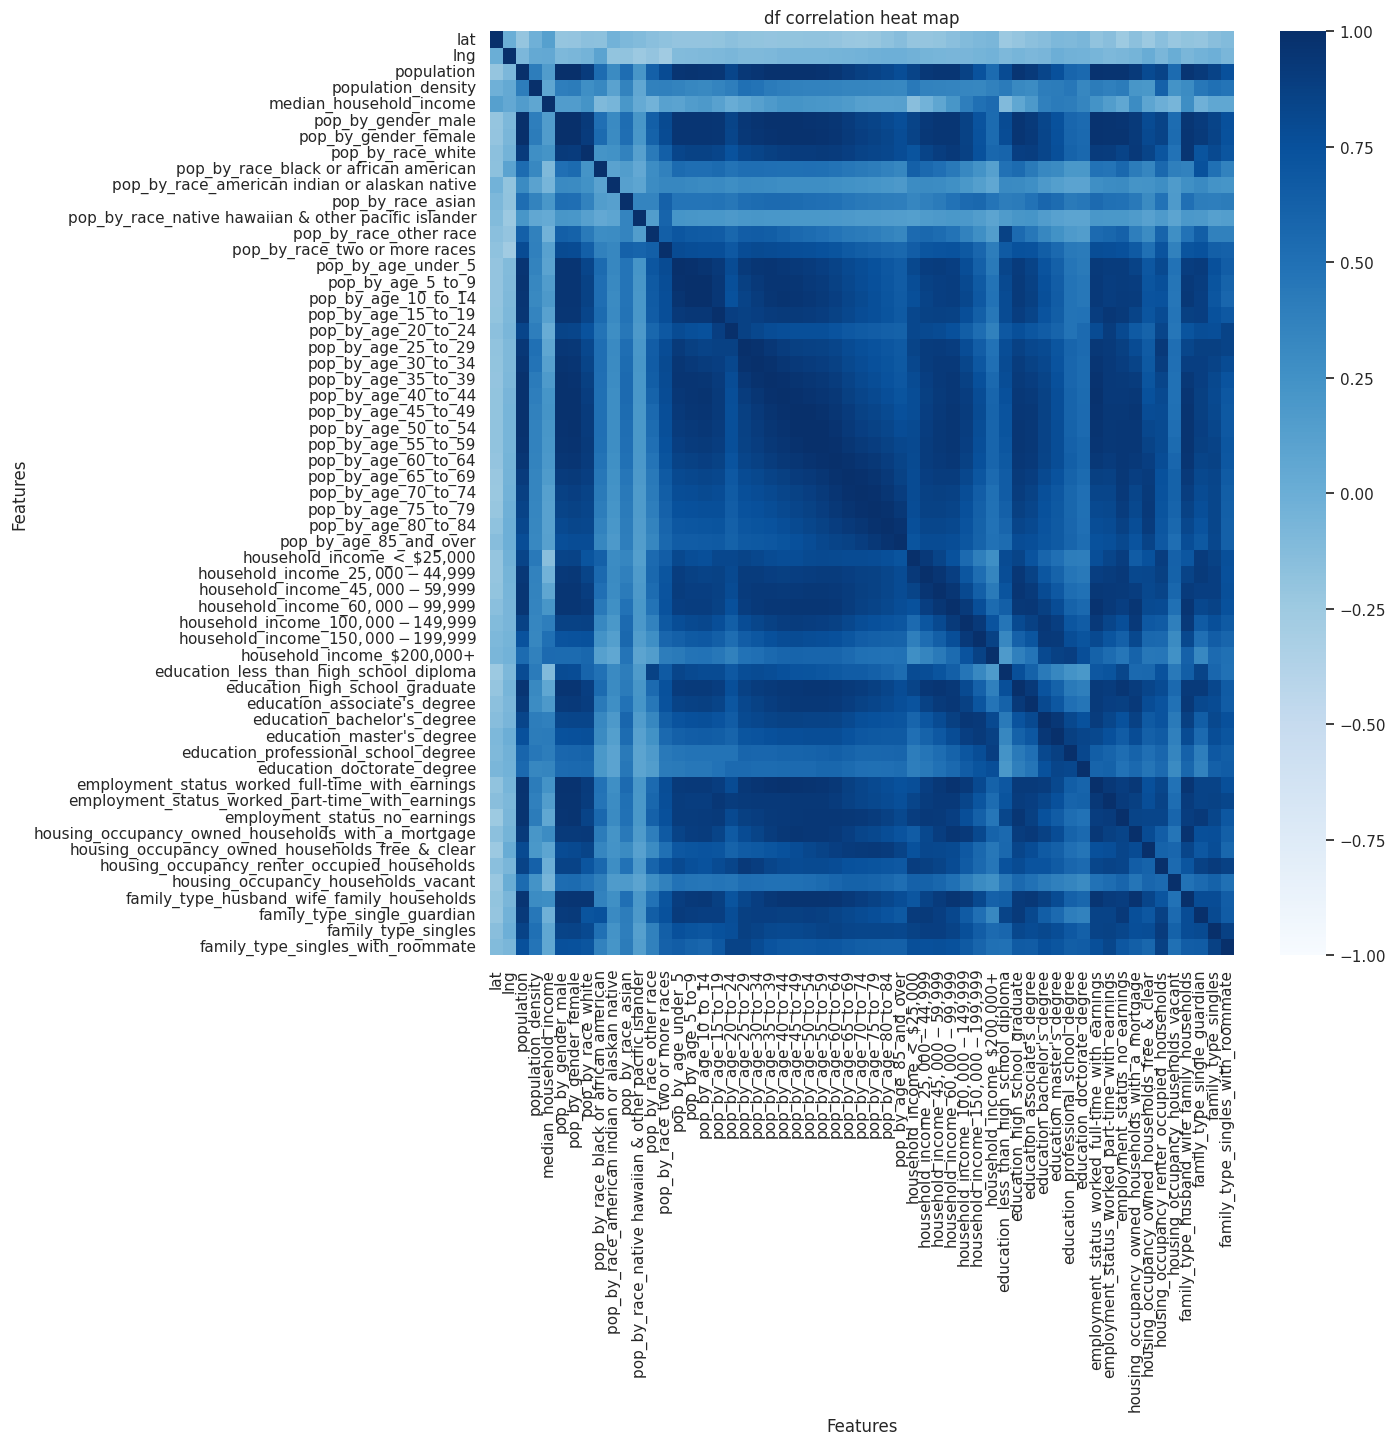

In [ ]:
#######################################
### Correlation Matrix
#######################################

fig, ax = plt.subplots(figsize=(12, 12))

# plotting correlation heatmap
corr_matrix = sns.heatmap(df.corr(), cmap="Blues", vmin=-1, vmax=1, center=0, 
                          ax=ax, xticklabels=True, yticklabels=True)
ax.set_title('df correlation heat map')
ax.set_xlabel("Features")
ax.set_ylabel("Features")

# displaying heatmap
plt.show()

## 2.2.) Explore Heart Data
In this section, we will explore the data we derived from the heart disease mortality rate dataset.

First, we'll plot Heart Disease Mortality Rates By State / US Territory.

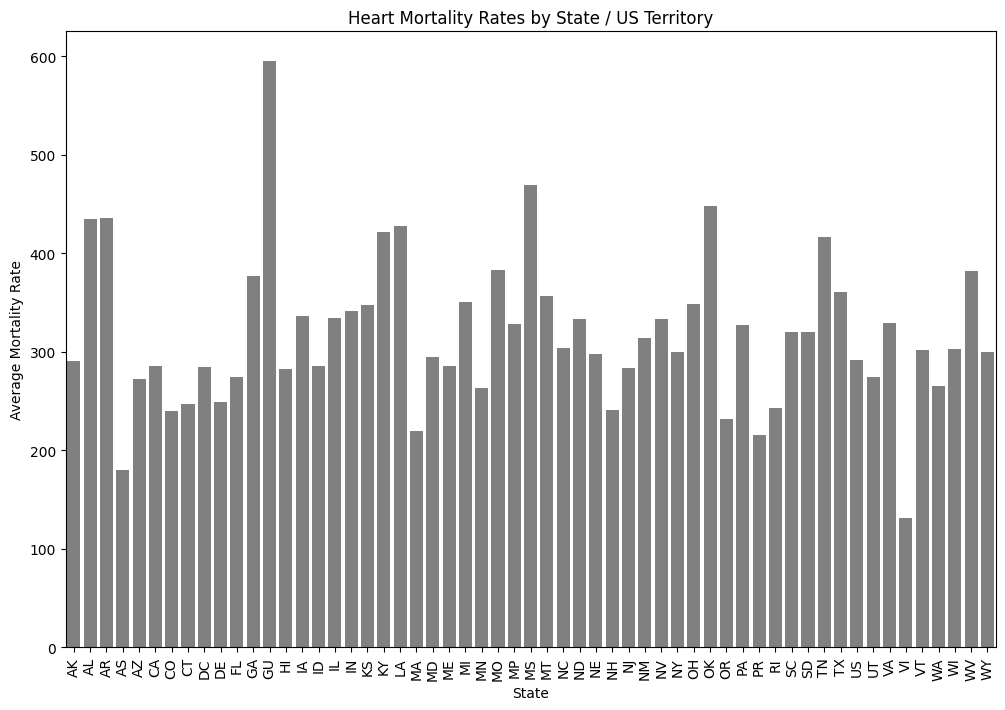

In [ ]:
###############################################
## Plot Mortality Rates By State / US Territory
###############################################

state_averages = heart.groupby('LocationAbbr')['Data_Value'].mean().reset_index()
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(state_averages, x = "LocationAbbr", y = 'Data_Value', color = "gray")
ax.set_xlabel('State')
ax.set_facecolor('white') 
ax.set_ylabel('Average Mortality Rate')
ax.grid(False)
ax.set_title('Heart Mortality Rates by State / US Territory')
plt.xticks(rotation=90)
plt.show()

Next, we'll look at some key stats of the Heart Disease Mortality Rate dataset.

In [ ]:
###################################################
## Create a table to view some key stats
###################################################

n_obs = len(heart)
n_zipcodes = len(heart['zip_code'].unique())
avg_rate = heart['Data_Value'].mean()

data = {'Statistics': ['Total Number of Observations', 
                       'Number of Unique Zip Codes', 
                       'Average Heart Disease Mortality'],

        'Values': [n_obs, 
                   n_zipcodes, 
                   avg_rate]}

table = pd.DataFrame(data=data)

# Style the table
table_style = table.style.set_properties(**{'text-align': 'left', 'border': '1px solid black',
                                             'font-size': '12pt', 'padding': '5px'}).set_table_styles(
                                                 [{    'selector': 'th',    'props': [(
                                                     'background-color', '#f2f2f2'), (
                                                         'border', '1px solid black'), (
                                                             'text-align', 'left'),
                                                              ('padding', '5px')] }, {
    'selector': 'td',
    'props': [('border', '1px solid black'), ('text-align', 'left'), ('padding', '5px')]
}]).format({'Values': '{:.1f}'}).set_caption('Summary Statistics, Heart Mortality Data')

# Print the styled table
display(table_style)

Lastly, we'll look at the zipcodes present in the Heart Disease Mortality Rate observations plotted against a map of the United States.

Please note that the legend represents total heart disease mortality rate per zipcode per 100,000 individuals.

From looking at the image, we concluded that heart disease mortality rates were higher in the southern part of the United States.

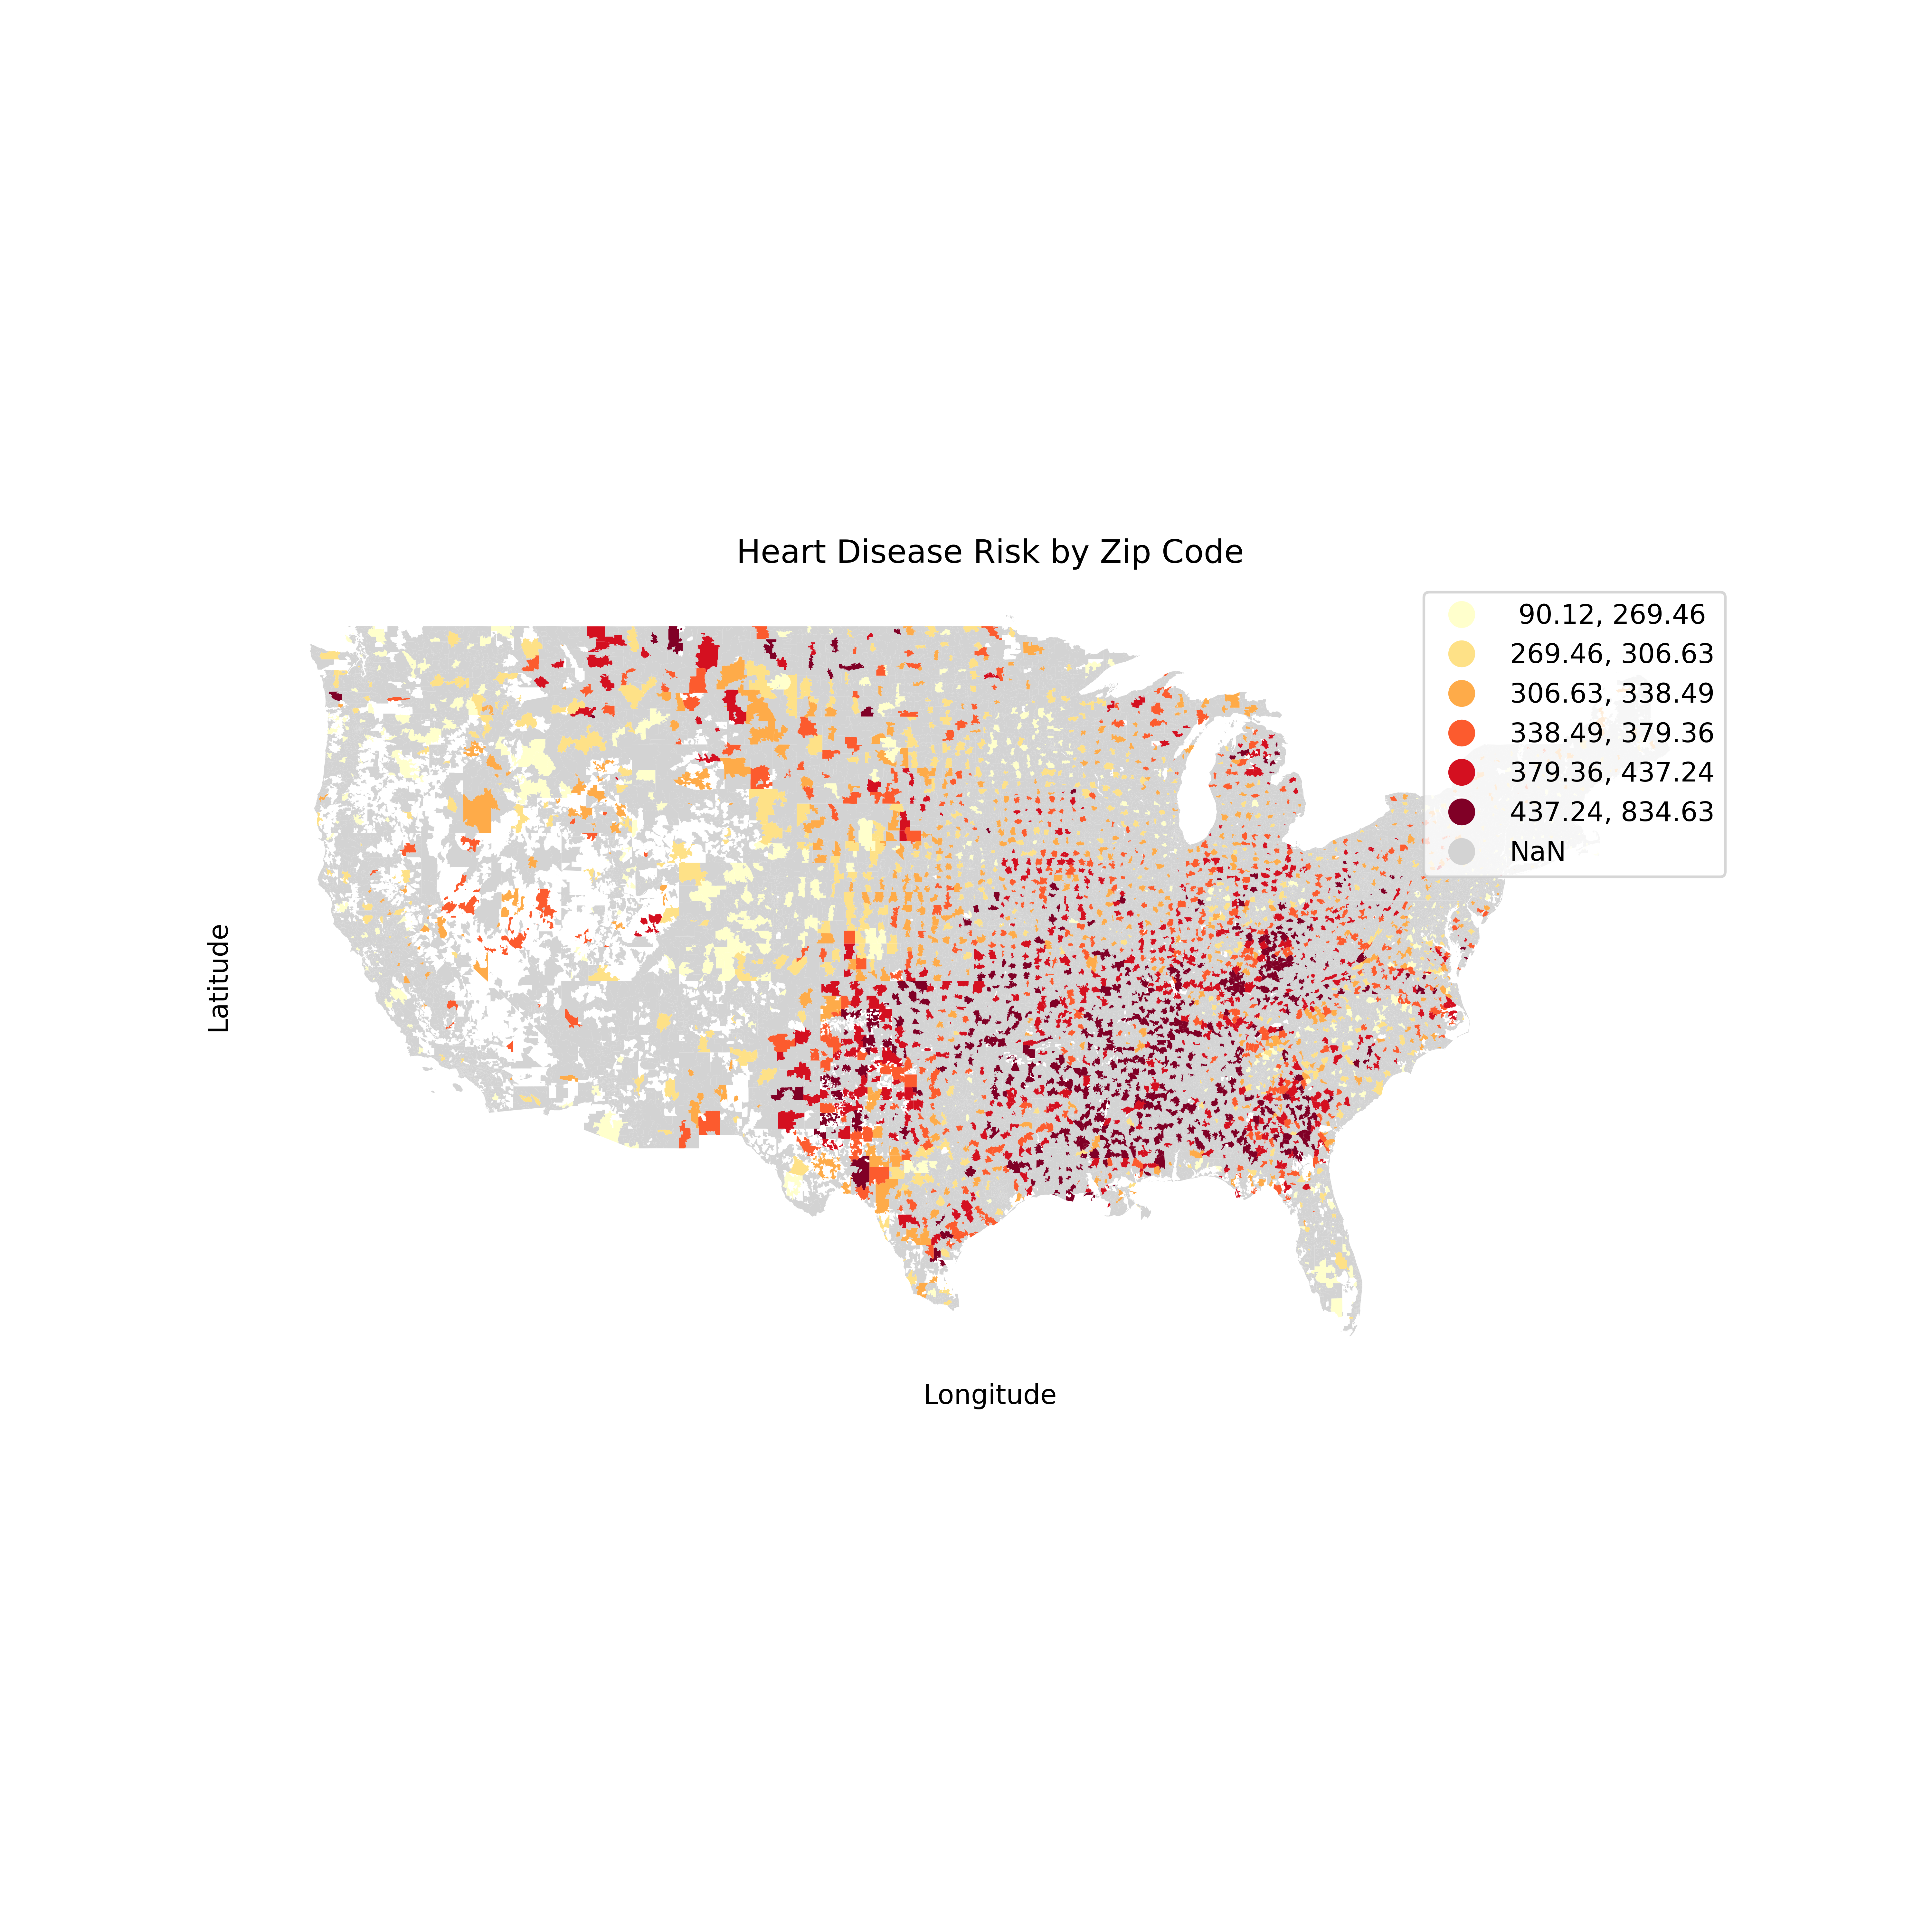

In [ ]:
## Note To Reader: The code below was used to generate the image shown below which has been saved locally to Google Drive.
## Left commented out for viewer reference.
# url = 'https://www2.census.gov/geo/tiger/TIGER2019/ZCTA5/tl_2019_us_zcta510.zip'
# zip_codes = gpd.read_file(url)
# def plot_heart_disease_by_zipcode(heartdata, geography):
#     bounds = (-125, 25, -67, 50)
#     all_data_heart = pd.merge(
#         heart, zip_codes, 
#         left_on='zip_code', right_on='ZCTA5CE10', how = 'right')
#     data_mean = all_data_heart.groupby('ZCTA5CE10')['Data_Value'].mean()
#     zip_codes_data = zip_codes.merge(data_mean, left_on='ZCTA5CE10', right_index=True)
#     zip_codes_data = zip_codes_data.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]]
#     fig, ax = plt.subplots(figsize=(10, 10))
#     cmap = plt.cm.get_cmap('YlOrRd')
#     missing_color = 'lightgray'
#     cmap.set_bad(color=missing_color)
#     zip_codes_data.plot(
#         column='Data_Value', cmap=cmap, ax=ax, scheme='quantiles', k=6, legend=True, \
#              missing_kwds={'color': missing_color})
#     ax.set_title('Heart Disease Risk by Zip Code')
#     ax.set_xlabel('Longitude')
#     ax.set_ylabel('Latitude')
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     plt.show()


######################################################################################################
## Visualize the Heart Dataset zip codes plotted on a map of the United States.
######################################################################################################
from IPython.display import Image
Image('../3output/heartdata_by_zip.png', width = 800)

## 2.3.) Merging Our Two DataFrames
Now that we've explored the two dataframes independently, we will merge them together.

In the below cell, we perform the following actions:
*  We merge the zipcode and heart disease dataframes on the zipcode column.
*  We remove any observations that don't contain population or heart disease data.
*  We drop unneeded feature columns (i.e. columns that all contain the same value, or columns that don't give us any important information).
*  We drop any observations with a 'geographic level' not set to 'county' (we're only using county-level observations for our model).
*  Lastly, we reorder the columns in the newly merged dataframe.

In [ ]:
#################################################################
## Create intermediate merged dataframe (all2) and 'clean it'
#################################################################

# merge the original DF and the heart DF on zip code columns
all2 = df.merge(heart, left_on='zipcode', right_on='zip_code', how = 'inner')

# drop any rows that don't include population or Data_Value
all2 = all2.dropna(subset = ['population', 'Data_Value'])

# Reduce the number of columns and focus the dataframe on usable data for our modeling.
all2 = all2.drop('Year', axis=1)                       # drop 'Year' column... same for every row (2018).
all2 = all2.drop('DataSource', axis=1)                 # drop 'DataSource' column... same for every row ('NVSS').
all2 = all2.drop('Class', axis=1)                      # drop 'Class' column... same for every row ('Cardiovascular Diseases').
all2 = all2.drop('Topic', axis=1)                      # drop 'Topic' column... same for every row ('Heart Disease Mortality').
all2 = all2.drop('Data_Value_Unit', axis=1)            # drop 'Data_Value_Unit' column... same for every row ('per 100,000 population').
all2 = all2.drop('Data_Value_Footnote_Symbol', axis=1) # drop 'Data_Value_Footnote_Symbol' column... same for every row ([nan]).
all2 = all2.drop('Data_Value_Footnote', axis=1)        # drop 'Data_Value_Footnote' column... same for every row ([nan]).
all2 = all2.drop('TopicID', axis=1)                    # drop 'TopicID' column... same for every row ('T2').
all2 = all2.drop('LocationID', axis=1)                 # drop 'LocationID' column... we already have zip code.
all2 = all2.drop('Y_lat', axis=1)                      # drop 'Y_lat' column... already have 'lat' column.
all2 = all2.drop('X_lon', axis=1)                      # drop 'X_lon' column... already have 'lng' column.
all2 = all2.drop('zip_code', axis=1)                   # drop 'zip_code' column... already have zipcode column.
# Not dropping 'LocationAbbr', state shortname - i.e. SD, ID, etc.
all2 = all2.drop('LocationDesc', axis=1)               # drop 'LocationDesc' column... already have 'county' column.
all2 = all2.drop('Data_Value_Type', axis=1)            # drop 'Data_Value_Type' column... Not used.
# for 'GeographicLevel', two options: ['State', 'County'] - State (754 rows), County (30743 rows).
all2 = all2[all2['GeographicLevel'] == 'County']       # only keep 'county'-level data - drops 754 rows of 'state'-level data.
all2 = all2.drop('GeographicLevel', axis=1)            # drop 'GeographicLevel' column... same for every row ('county').

## Reorganize the remaining columns
all2 = all2[['zipcode', 'lat', 'lng', 'county', 'LocationAbbr', 'Data_Value', 
             'StratificationCategory1', 'Stratification1', 'StratificationCategory2', 
             'Stratification2', 'population', 'population_density', 'median_household_income', 
             'pop_by_gender_male', 'pop_by_gender_female', 'pop_by_race_white', 
             'pop_by_race_black or african american', 'pop_by_race_american indian or alaskan native', 
             'pop_by_race_asian', 'pop_by_race_native hawaiian & other pacific islander', 
             'pop_by_race_other race', 'pop_by_race_two or more races', 'pop_by_age_under_5', 
             'pop_by_age_5_to_9', 'pop_by_age_10_to_14', 'pop_by_age_15_to_19', 'pop_by_age_20_to_24', 
             'pop_by_age_25_to_29', 'pop_by_age_30_to_34', 'pop_by_age_35_to_39', 'pop_by_age_40_to_44', 
             'pop_by_age_45_to_49', 'pop_by_age_50_to_54', 'pop_by_age_55_to_59', 'pop_by_age_60_to_64',
             'pop_by_age_65_to_69', 'pop_by_age_70_to_74', 'pop_by_age_75_to_79', 'pop_by_age_80_to_84',
             'pop_by_age_85_and_over', 'household_income_<_$25,000', 'household_income_$25,000-$44,999',
             'household_income_$45,000-$59,999', 'household_income_$60,000-$99,999', 
             'household_income_$100,000-$149,999', 'household_income_$150,000-$199,999',
             'household_income_$200,000+', 'education_less_than_high_school_diploma', 
             'education_high_school_graduate', "education_associate's_degree", 
             "education_bachelor's_degree", "education_master's_degree", 
             'education_professional_school_degree', 'education_doctorate_degree',
             'employment_status_worked_full-time_with_earnings', 'employment_status_worked_part-time_with_earnings',
             'employment_status_no_earnings', 'housing_occupancy_owned_households_with_a_mortgage', 
             'housing_occupancy_owned_households_free_&_clear', 'housing_occupancy_renter_occupied_households',
             'housing_occupancy_households_vacant', 'family_type_husband_wife_family_households', 
             'family_type_single_guardian', 'family_type_singles', 'family_type_singles_with_roommate']]

# print the resulting 'intermediate merged dataframe.
all2.head()

zipcode   lat     lng            county LocationAbbr  Data_Value StratificationCategory1 Stratification1 StratificationCategory2 Stratification2  population  population_density  median_household_income  pop_by_gender_male  pop_by_gender_female  \
0   94062  37.4 -122.29  San Mateo County           CA       208.9                  Gender         Overall          Race/Ethnicity         Overall       25876               365.0                   125060               12710                 13166   
1   94062  37.4 -122.29  San Mateo County           CA       271.2                  Gender            Male          Race/Ethnicity         Overall       25876               365.0                   125060               12710                 13166   
2   94062  37.4 -122.29  San Mateo County           CA       157.1                  Gender          Female          Race/Ethnicity         Overall       25876               365.0                   125060               12710                 13166   
3   94062  37.4 -122.29  San Mateo County           CA       239.4                  Gender         Overall          Race/Ethnicity           White       25876               365.0                   125060               12710                 13166   
4   94062  37.4 -122.29  San Mateo County           CA       305.6                  Gender            Male          Race/Ethnicity           White       25876               365.0                   125060               12710                 13166   

   pop_by_race_white  pop_by_race_black or african american  pop_by_race_american indian or alaskan native  pop_by_race_asian  pop_by_race_native hawaiian & other pacific islander  pop_by_race_other race  pop_by_race_two or more races  \
0              21134                                    286                                             60               1743                                                 97                       1416                           1140   
1              21134                                    286                                             60               1743                                                 97                       1416                           1140   
2              21134                                    286                                             60               1743                                                 97                       1416                           1140   
3              21134                                    286                                             60               1743                                                 97                       1416                           1140   
4              21134                                    286                                             60               1743                                                 97                       1416                           1140   

   pop_by_age_under_5  pop_by_age_5_to_9  pop_by_age_10_to_14  pop_by_age_15_to_19  pop_by_age_20_to_24  pop_by_age_25_to_29  pop_by_age_30_to_34  pop_by_age_35_to_39  pop_by_age_40_to_44  pop_by_age_45_to_49  pop_by_age_50_to_54  \
0                1429               1629                 1628                 1430                  979                 1063                 1240                 1545                 2068                 2433                 2446   
1                1429               1629                 1628                 1430                  979                 1063                 1240                 1545                 2068                 2433                 2446   
2                1429               1629                 1628                 1430                  979                 1063                 1240                 1545                 2068                 2433                 2446   
3                1429               1629                 1628                 1430                  979                 1063                 1240 

Next, we want to view some of the key stats on this newly merged dataframe to determine if there is anything else that can be improved. We mostly focus on the 'stratification values' given from the heart disease dataset to determine which observations we want to keep for our modeling.

In [ ]:
###################################################
## Create a table to view some key stats
###################################################

n_obs = len(all2)
max_data_value    = max(all2['Data_Value'])
avg_rate          = all2['Data_Value'].mean()
min_data_value    = min(all2['Data_Value'])
n_Strat1_Overall  = len(all2[ all2['Stratification1'] == 'Overall'])
n_Strat1_Male     = len(all2[ all2['Stratification1'] == 'Male'])
n_Strat1_Female   = len(all2[ all2['Stratification1'] == 'Female'])
n_Strat2_Overall  = len(all2[ all2['Stratification2'] == 'Overall'])
n_Strat2_White    = len(all2[ all2['Stratification2'] == 'White'])
n_Strat2_Black    = len(all2[ all2['Stratification2'] == 'Black'])
n_Strat2_Hispanic = len(all2[ all2['Stratification2'] == 'Hispanic'])
n_Strat2_API      = len(all2[ all2['Stratification2'] == 'Asian and Pacific Islander'])
n_Strat2_AIAN     = len(all2[ all2['Stratification2'] == 'American Indian and Alaskan Native'])
n_Overall_Overall = len(all2[(all2['Stratification1'] == 'Overall') & (all2['Stratification2'] == 'Overall')])

data = {'Statistics': [
                       'Total Number of Observations', 
                       'Maximum Heart Disease Mortality Rate', 
                       'Average Heart Disease Mortality',
                       'Minimum Heart Disease Mortality Rate',
                       'Number of Stratification 1 Overall Observations',
                       'Number of Stratification 1 Male Observations',
                       'Number of Stratification 1 Female Observations',
                       'Number of Stratification 2 Overall Observations',
                       'Number of Stratification 2 White Observations',
                       'Number of Stratification 2 Black Observations',
                       'Number of Stratification 2 Hispanic Observations',
                       'Number of Stratification 2 Asian and Pacific Islander Observations',
                       'Number of Stratification 2 American Indian and Alaskan Native Observations',
                       'Number of Observations with Both Stratifications Displaying \"Overall\"'
                       ],

        'Values': [
                   n_obs, 
                   max_data_value, 
                   avg_rate,
                   min_data_value,
                   n_Strat1_Overall,
                   n_Strat1_Male,
                   n_Strat1_Female,
                   n_Strat2_Overall,
                   n_Strat2_White,
                   n_Strat2_Black,
                   n_Strat2_Hispanic,
                   n_Strat2_API,
                   n_Strat2_AIAN,
                   n_Overall_Overall
                   ]}

table = pd.DataFrame(data=data)

# Style the table
table_style = table.style.set_properties(**{'text-align': 'left', 'border': '1px solid black',
                                            'font-size': '12pt', 'padding': '5px'}).set_table_styles(
                                                [{    'selector': 'th', 
                                                  'props': [('background-color', '#f2f2f2'), 
                                                            ('border', '1px solid black'), 
                                                            ('text-align', 'left'),
                                                            ('padding', '5px')] }, { 
                                                                'selector': 'td', 'props': [
                                                                    ('border', '1px solid black'), 
                                                                    ('text-align', 'left'), 
                                                                    ('padding', '5px')]}]).format(
                                                                        {'Values': '{:.1f}'}).set_caption(
                                                                            'Summary Statistics, Intermediate Merged DataFrame')

# Print the styled table
display(table_style)

Next, we'll make a few updates to our intermediate dataframe (all2) to create our final merged dataframe (all3).

Our dataset contains two columns 'Stratification1' and 'Stratification2' that describe the population which is being represented by that particular data tuple. Stratification1 describes the population's gender. Stratification2 describes the population's race/ethnicity. A value of 'Overall' in either of these columns indicates that that data tuple represents all genders or all races/enthicities within the related zipcode.

Improvements include:

*   Converting all features to percentages rather than totals
*   Remove any observations that don't have stratification values of "Overall"
*   Create a column encoding Data_Value based on whether or not the value is above the average
*   Reordering the remaining columns



In [ ]:
############################################
## Create all3 dataframe
############################################

# print(all2.columns.tolist())

all3 = all2.copy()

# 1.) convert feature columns to percentages rather than totals
variables_to_convert = ['pop_by_gender_male', 'pop_by_gender_female', 'pop_by_race_white',
                        'pop_by_race_black or african american', 'pop_by_race_american indian or alaskan native', 
                        'pop_by_race_asian', 'pop_by_race_native hawaiian & other pacific islander',
                        'pop_by_race_other race', 'pop_by_race_two or more races', 'pop_by_age_under_5', 
                        'pop_by_age_5_to_9', 'pop_by_age_10_to_14', 'pop_by_age_15_to_19', 
                        'pop_by_age_20_to_24', 'pop_by_age_25_to_29', 'pop_by_age_30_to_34', 
                        'pop_by_age_35_to_39', 'pop_by_age_40_to_44', 'pop_by_age_45_to_49', 
                        'pop_by_age_50_to_54', 'pop_by_age_55_to_59', 'pop_by_age_60_to_64', 
                        'pop_by_age_65_to_69', 'pop_by_age_70_to_74', 'pop_by_age_75_to_79',
                        'pop_by_age_80_to_84', 'pop_by_age_85_and_over', 'household_income_<_$25,000', 
                        'household_income_$25,000-$44,999', 'household_income_$45,000-$59,999', 
                        'household_income_$60,000-$99,999', 'household_income_$100,000-$149,999'
                        , 'household_income_$150,000-$199,999', 'household_income_$200,000+', 
                        'education_less_than_high_school_diploma', 'education_high_school_graduate',
                        "education_associate's_degree", "education_bachelor's_degree", 
                        "education_master's_degree", 'education_professional_school_degree', 
                        'education_doctorate_degree', 'employment_status_worked_full-time_with_earnings',
                        'employment_status_worked_part-time_with_earnings', 'employment_status_no_earnings',
                        'housing_occupancy_owned_households_with_a_mortgage', 'housing_occupancy_owned_households_free_&_clear',
                        'housing_occupancy_renter_occupied_households', 'housing_occupancy_households_vacant',
                        'family_type_husband_wife_family_households', 'family_type_single_guardian',
                        'family_type_singles', 'family_type_singles_with_roommate']

all3[variables_to_convert] = all3[variables_to_convert].apply(lambda x: x/all2['population'])

# 2.) only keep the overall, overall stratifications
all3 = all3[(all3['Stratification1'] == 'Overall') & (all3['Stratification2'] == 'Overall')]
all3 = all3.drop(['StratificationCategory1', 'Stratification1', 'StratificationCategory2', 'Stratification2'], 
                 axis=1) # remove the stratification columns now that they're all overall, overall

# 3.) create new column encoding the Data_Value column to determine if the county's heart mortality rate is above or below average.
# if Data_value is greater than average --> 1
# if Data_value is less than or equal to average --> 0
average_heart_mortality_per_county = all3['Data_Value'].mean()
all3['OHE_Data_Value'] = all3['Data_Value'].apply(lambda x: 0 if x <= average_heart_mortality_per_county else 1)

# 4.) Reorder the columns
all3 = all3[['zipcode', 'lat', 'lng', 'county', 'LocationAbbr', 'OHE_Data_Value', 
             'Data_Value', 'population', 'population_density', 'median_household_income', 
             'pop_by_gender_male', 'pop_by_gender_female', 'pop_by_race_white', 
             'pop_by_race_black or african american', 'pop_by_race_american indian or alaskan native', 
             'pop_by_race_asian', 'pop_by_race_native hawaiian & other pacific islander', 
             'pop_by_race_other race', 'pop_by_race_two or more races', 'pop_by_age_under_5', 
             'pop_by_age_5_to_9', 'pop_by_age_10_to_14', 'pop_by_age_15_to_19', 'pop_by_age_20_to_24',
             'pop_by_age_25_to_29', 'pop_by_age_30_to_34', 'pop_by_age_35_to_39', 'pop_by_age_40_to_44', 
             'pop_by_age_45_to_49', 'pop_by_age_50_to_54', 'pop_by_age_55_to_59', 'pop_by_age_60_to_64',
             'pop_by_age_65_to_69', 'pop_by_age_70_to_74', 'pop_by_age_75_to_79', 'pop_by_age_80_to_84', 
             'pop_by_age_85_and_over', 'household_income_<_$25,000', 'household_income_$25,000-$44,999',
             'household_income_$45,000-$59,999', 'household_income_$60,000-$99,999', 
             'household_income_$100,000-$149,999', 'household_income_$150,000-$199,999',
             'household_income_$200,000+', 'education_less_than_high_school_diploma', 
             'education_high_school_graduate', "education_associate's_degree", "education_bachelor's_degree",
             "education_master's_degree", 'education_professional_school_degree', 'education_doctorate_degree',
             'employment_status_worked_full-time_with_earnings', 'employment_status_worked_part-time_with_earnings',
             'employment_status_no_earnings', 'housing_occupancy_owned_households_with_a_mortgage', 
             'housing_occupancy_owned_households_free_&_clear', 'housing_occupancy_renter_occupied_households',
             'housing_occupancy_households_vacant', 'family_type_husband_wife_family_households', 
             'family_type_single_guardian', 'family_type_singles', 'family_type_singles_with_roommate']]

# this dataframe has the data_value and all features in percentage of population.
all3.head()

zipcode    lat     lng                county LocationAbbr  OHE_Data_Value  Data_Value  population  population_density  median_household_income  pop_by_gender_male  pop_by_gender_female  pop_by_race_white  pop_by_race_black or african american  \
0    94062  37.40 -122.29      San Mateo County           CA               0       208.9       25876               365.0                   125060            0.491189              0.508811           0.816741                               0.011053   
18   94114  37.75 -122.43  San Francisco County           CA               0       210.9       31124             21837.0                   114689            0.591055              0.408945           0.795431                               0.019278   
36   94946  38.07 -122.68          Marin County           CA               0       173.1         699                16.0                   131250            0.522175              0.477825           0.892704                               0.007153   
54   97722  42.91 -118.65         Harney County           OR               0       307.1          91                 0.0                    49063            0.527473              0.472527           1.000000                               0.000000   
72   94574  38.55 -122.39           Napa County           CA               0       257.0        8742                68.0                    83551            0.479067              0.520933           0.793983                               0.005033   

    pop_by_race_american indian or alaskan native  pop_by_race_asian  pop_by_race_native hawaiian & other pacific islander  pop_by_race_other race  pop_by_race_two or more races  pop_by_age_under_5  pop_by_age_5_to_9  pop_by_age_10_to_14  \
0                                        0.002319           0.067360                                           0.003749                   0.054723                       0.044056            0.055225           0.062954             0.062915   
18                                       0.004466           0.103393                                           0.001317                   0.028724                       0.047391            0.042668           0.026989             0.017575   
36                                       0.001431           0.017167                                           0.001431                   0.062947                       0.017167            0.030043           0.050072             0.077253   
54                                       0.000000           0.000000                                           0.000000                   0.000000                       0.000000            0.065934           0.120879             0.109890   
72                                       0.006177           0.018302                                           0.001601                   0.150080                       0.024823            0.048158           0.056738             0.061428   

    pop_by_age_15_to_19  pop_by_age_20_to_24  pop_by_age_25_to_29  pop_by_age_30_to_34  pop_by_age_35_to_39  pop_by_age_40_to_44  pop_by_age_45_to_49  pop_by_age_50_to_54  pop_by_age_55_to_59  pop_by_age_60_to_64  pop_by_age_65_to_69  \
0              0.055264             0.037834             0.041081             0.047921             0.059708             0.079920             0.094025             0.094528             0.082122             0.073891             0.051090   
18             0.016386             0.034571             0.103168             0.126815             0.121193             0.115602             0.098991             0.076308             0.069046             0.056259             0.036403   
36             0.061516             0.031474             0.035765             0.051502             0.055794             0.075823             0.065808             0.115880             0.100143             0.094421             0.078684   
54             0.010989             0.021978             0.065934             0.087912             0.043956      

Below, we'll look at some of the key stats from our final merged dataframe.

In [ ]:
###################################################
## Create a table to view some key stats
###################################################

n_obs = len(all3)
above_avg_HDM = len(all3[all3['OHE_Data_Value'] == 1])
below_avg_HDM =  len(all3[all3['OHE_Data_Value'] == 0])

data = {'Statistics': [
                       'Total Number of Observations', 
                       'Number of counties with above-average Heart Disease Mortality Rates', 
                       'Number of counties with below-average Heart Disease Mortality Rates',
                       ],

        'Values': [
                   n_obs, 
                   above_avg_HDM,
                   below_avg_HDM
                   ]}

table = pd.DataFrame(data=data)

# Style the table
table_style = table.style.set_properties(**{'text-align': 'left', 
                                            'border': '1px solid black',
                                            'font-size': '12pt', 'padding': '5px'}
                                         ).set_table_styles([{   
                                              'selector': 'th',  
                                                'props': [('background-color', '#f2f2f2'), 
                                                          ('border', '1px solid black'),
                                                          ('text-align', 'left'),('padding', '5px')]
                                                           }, { 'selector': 'td', 
                                                               'props': [('border', 
                                                                          '1px solid black'),
                                                                          ('text-align', 'left'), 
                                                                         ('padding', '5px')]}]).format(
                                                                             {'Values': '{:.1f}'}
                                                                             ).set_caption(
                                                                                 'Summary Statistics, Final Merged DataFrame')

# Print the styled table
display(table_style)

# 3.) Modeling

This section is dedicated to developing and implementing models using the data to make predictions upon and heart disease mortality rate conditions. As previously mentioned, our analysis involves modeling techniques such as Logistic Regressions (with and without PCA), Linear Regressions (with and without L1 Regularization), and Random Forest. We select a set of predictor variables and split the dataset into training and testing sets. And we use metrics such as accuracy, f1 score, mean squared error (MSE), and R2 to evaluate how well we can predict heart disease rates across various zip codes in the Unites States.

## 3.1.) Logistic Regression

We'll first run a Logistic Regression model using our final merged dataset and all features.

In [ ]:
##############################################
## Testing with a logistic regression
##############################################

# Choose predictor variables from the df dataset - using all predictors below.
predictors = ['population', 'population_density', 'median_household_income', 
              'pop_by_gender_male', 'pop_by_gender_female', 'pop_by_race_white',
              'pop_by_race_black or african american', 'pop_by_race_american indian or alaskan native',
              'pop_by_race_asian', 'pop_by_race_native hawaiian & other pacific islander',
              'pop_by_race_other race', 'pop_by_race_two or more races', 'pop_by_age_under_5', 
              'pop_by_age_5_to_9', 'pop_by_age_10_to_14', 'pop_by_age_15_to_19', 'pop_by_age_20_to_24', 
              'pop_by_age_25_to_29', 'pop_by_age_30_to_34', 'pop_by_age_35_to_39', 'pop_by_age_40_to_44',
              'pop_by_age_45_to_49', 'pop_by_age_50_to_54', 'pop_by_age_55_to_59', 'pop_by_age_60_to_64',
              'pop_by_age_65_to_69', 'pop_by_age_70_to_74', 'pop_by_age_75_to_79', 'pop_by_age_80_to_84',
              'pop_by_age_85_and_over', 'household_income_<_$25,000', 'household_income_$25,000-$44,999',
              'household_income_$45,000-$59,999', 'household_income_$60,000-$99,999',
              'household_income_$100,000-$149,999', 'household_income_$150,000-$199,999',
              'household_income_$200,000+', 'education_less_than_high_school_diploma', 
              'education_high_school_graduate', "education_associate's_degree", "education_bachelor's_degree",
              "education_master's_degree", 'education_professional_school_degree', 'education_doctorate_degree',
              'employment_status_worked_full-time_with_earnings', 'employment_status_worked_part-time_with_earnings', 
              'employment_status_no_earnings', 'housing_occupancy_owned_households_with_a_mortgage', 
              'housing_occupancy_owned_households_free_&_clear', 'housing_occupancy_renter_occupied_households', 
              'housing_occupancy_households_vacant', 'family_type_husband_wife_family_households',
              'family_type_single_guardian', 'family_type_singles', 'family_type_singles_with_roommate']

# Set up X and y variables
X = all3[predictors]
y = all3['OHE_Data_Value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Import required libraries
from sklearn.linear_model import LogisticRegression

# Initialize model with default parameters and fit it on the training set
model = LogisticRegression(fit_intercept = True)
logistic_reg = model.fit(X_train,y_train)

# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = logistic_reg.predict(X_test)

# Find the accuracy and store the value in `log_acc`
logistic_regression_accuracy = logistic_reg.score(X_test, y_test)

from sklearn.metrics import accuracy_score, f1_score

print("##########################################")
print("Logistic Regression without PCA")
print("##########################################")

y_train_pred = logistic_reg.predict(X_train)
print("Train Accuracy:", round(accuracy_score(y_train, y_train_pred), 3) )
print("Train F-1:",      round(f1_score(y_train, y_train_pred), 3) )
logreg_train_acc = round(accuracy_score(y_train, y_train_pred), 3)
logreg_train_f1 = round(f1_score(y_train, y_train_pred), 3)

print("##########################################")

y_test_pred = logistic_reg.predict(X_test)
print("Test Accuracy:", round(accuracy_score(y_test, y_test_pred), 3))
print("Test F-1:",      round(f1_score(y_test, y_test_pred), 3))
logreg_test_acc = round(accuracy_score(y_test, y_test_pred), 3)
logreg_test_f1  = round(f1_score(y_test, y_test_pred), 3)

print("##########################################")

##########################################
Logistic Regression without PCA
##########################################
Train Accuracy: 0.55
Train F-1: 0.045
##########################################
Test Accuracy: 0.569
Test F-1: 0.064
##########################################


In the confusion matrix below, you can see that the logistc regression model is predicting 'below average' very often, which is resulting in a large number of false negatives.

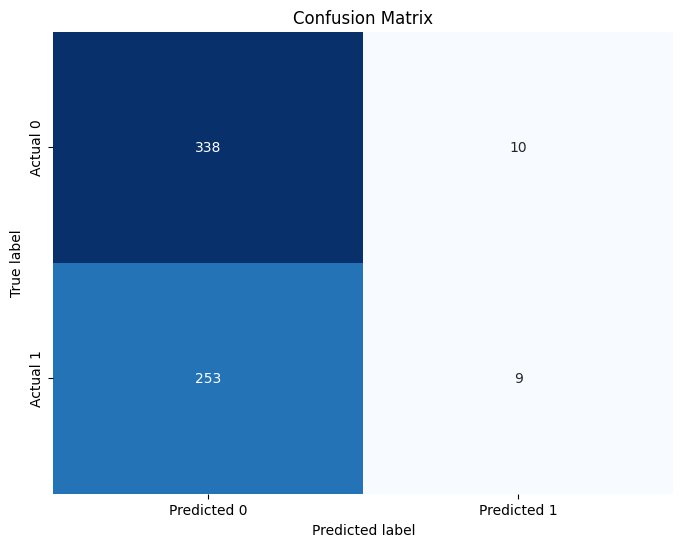

In [ ]:
# Compute the confusion matrix for test predictions
cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

##3.2.) Logistic Regression with PCA

Now, we'll use PCA to only use the most critical features for making predictions.

Based on the graph below, we'll use the value 17 for our number of PCA components as that it just above the 80% variance threshold.

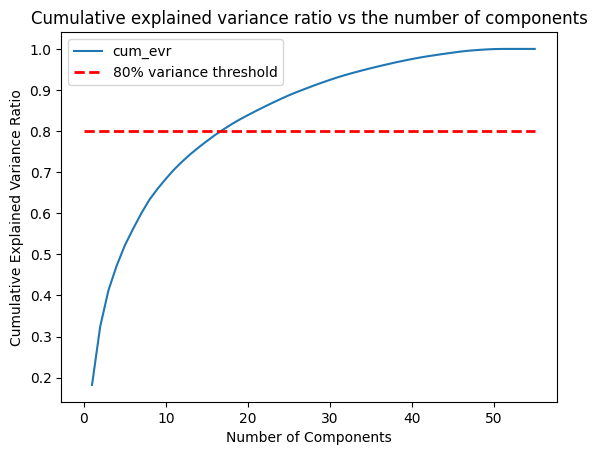

In [ ]:
# PCA to Reduce Dimensionality
# Import libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Intermediate step to address scale-invariance
X1 = X.copy()

scaled_X1 = StandardScaler().fit_transform(X1)

X1_train, X1_test, y1_train, y1_test = train_test_split(scaled_X1, y, test_size=0.2, random_state=42)

# Instantiate and Fit PCA
pca = PCA()
pca.fit(X1_train)

explained_variance_ratios = pca.explained_variance_ratio_

cum_evr=np.cumsum(pca.explained_variance_ratio_)

number_of_components = []

for i in range(0,len(cum_evr)):
  number_of_components.append(i+1)

data = {'Number of Components': number_of_components,
        'Cumulative Explained Variance Ratio': cum_evr}

cum_evr_df = pd.DataFrame(data)

graph = sns.lineplot(x="Number of Components", y="Cumulative Explained Variance Ratio", 
                     data=cum_evr_df, markers=True, label="cum_evr")

graph.set_title("Cumulative explained variance ratio vs the number of components")

graph.hlines(y=0.8, xmin=0, xmax=55, linewidth=2, color='r', linestyle='dashed',
             label="80% variance threshold")

plt.legend()

plt.show()

In [ ]:
## Final PCA

num_principal_components = 17 # derived from finding the "knee" in the plot above.

X2 = X.copy()

scaled_X2 = StandardScaler().fit_transform(X2)

X2_train, X2_test, y2_train, y2_test = train_test_split(scaled_X2, y, test_size=0.2, random_state=42)

pca_refit = PCA(n_components=num_principal_components)

pca_refit.fit(X2_train)

# Transform on Testing Set and store it as `x_test_pca`
x_test_pca = pca_refit.transform(X2_test)


##################################################
## perform actual logistic regression with PCA
##################################################

# Initialize `log_reg_pca` model with default parameters and fit it on the PCA transformed training set
X_train_pca_fit = pca_refit.transform(X2_train)
log_reg_pca = LogisticRegression()
log_reg_pca.fit(X_train_pca_fit, y_train)

# Use the model to predict on the PCA transformed test set and save these predictions as `y_pred`
y_pred = log_reg_pca.predict(x_test_pca)

# Find the accuracy and store the value in `test_accuracy`
test_accuracy = log_reg_pca.score(x_test_pca, y2_test)

from sklearn.metrics import accuracy_score, f1_score

print("##########################################")
print("Logistic Regression with PCA")
print("##########################################")

y_train_pred = log_reg_pca.predict(X_train_pca_fit)
print("Train Accuracy:", round(accuracy_score(y_train, y_train_pred), 3) )
print("Train F-1:",      round(f1_score(y_train, y_train_pred), 3) )
pcalogreg_train_acc = round(accuracy_score(y_train, y_train_pred), 3)
pcalogreg_train_f1 = round(f1_score(y_train, y_train_pred), 3)

print("##########################################")

y_test_pred = log_reg_pca.predict(x_test_pca)
print("Test Accuracy:", round(accuracy_score(y_test, y_test_pred), 3))
print("Test F-1:",      round(f1_score(y_test, y_test_pred), 3))
pcalogreg_test_acc =round(accuracy_score(y_test, y_test_pred), 3)
pcalogreg_test_f1 = round(f1_score(y_test, y_test_pred), 3)

print("##########################################")

##########################################
Logistic Regression with PCA
##########################################
Train Accuracy: 0.747
Train F-1: 0.705
##########################################
Test Accuracy: 0.721
Test F-1: 0.66
##########################################


The confusion plot below results in a significantly lower number of false negatives than the one we viewed with logistic regression without PCA.

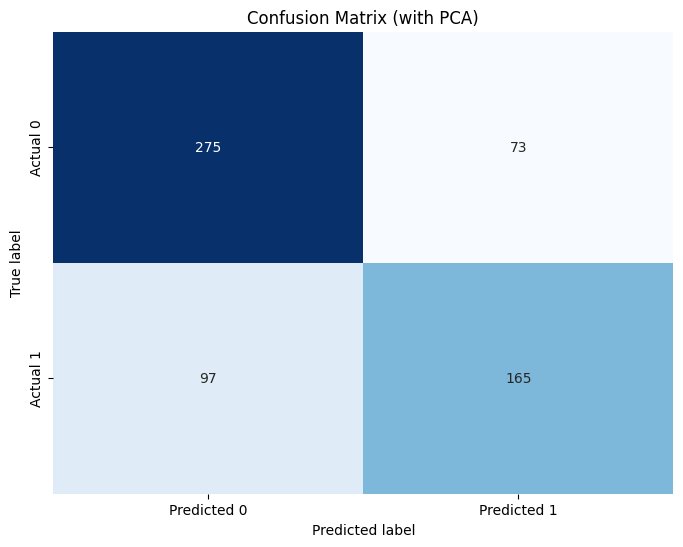

In [ ]:
# Compute the confusion matrix for your PCA test predictions
cm_pca = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix (with PCA)')
plt.show()

The below cell outputs a table with the various principal components in order from most to least important.

In [ ]:
########################################################################
## Show the Principal Components in order of most to least important
########################################################################

# Get the most important component locations
most_important_pcs = []
for i in range(num_principal_components): 
  most_important_pcs.append(np.abs(pca_refit.components_[i]).argmax())

# get the feature names for the most important principal components
most_important_pc_names = []
for i in range(num_principal_components):
  most_important_pc_names.append(predictors[most_important_pcs[i]])

# Take the feature names and put them into a dictionary
pc_dic = {}
for i in range(num_principal_components):
  pc_dic['PC'+str(i+1)] = most_important_pc_names[i]

# make the dictionary into a dataframe
pc_df = pd.DataFrame(pc_dic.items(), columns=['Principal Component', 'Feature Name'])

pc_df

Principal Component                                       Feature Name
0                  PC1                                pop_by_age_70_to_74
1                  PC2                            median_household_income
2                  PC3                  family_type_singles_with_roommate
3                  PC4                                 pop_by_gender_male
4                  PC5                                  pop_by_race_white
5                  PC6                                pop_by_age_15_to_19
6                  PC7  pop_by_race_native hawaiian & other pacific is...
7                  PC8                             pop_by_race_other race
8                  PC9      pop_by_race_american indian or alaskan native
9                 PC10                             pop_by_age_85_and_over
10                PC11      pop_by_race_american indian or alaskan native
11                PC12                                 population_density
12                PC13                                 population_density
13                PC14                                pop_by_age_45_to_49
14                PC15                   household_income_$45,000-$59,999
15                PC16                       education_associate's_degree
16                PC17                       education_associate's_degree

We are evaulating our models using both accuracy and F1-score metrics. Accuracy can be misleading in imbalanced datasets, as a high accuracy can be achieved by predicting the majority class without effectively addressing the minority class. In these situations, F1-score, which is the harmonic mean of precision and recall, provides a better representation of the model's performance on both classes.

Evaluating models with both accuracy and F1-score enables a comprehensive understanding of their strengths and weaknesses. While accuracy gives an overall sense of correctness, F1-score reveals the trade-off between precision and recall.

## 3.3.) OLS Model
In this section, we will use a linear model to make predictions using our data.

In [ ]:
#############################################################################
# SIMPLE LINEAR MODEL
#############################################################################


from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")

# Set up X and y variables
X = all3[predictors]
y = all3['Data_Value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

# Train the model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Predict on train data and calculate MSE and R-squared

print("##########################################")
print("Linear Regression")
print("##########################################")
y_train_pred = lm.predict(X_train)
print("Train MSE:", round(mean_squared_error(y_train, y_train_pred), 3))
print("Train MAE:", round(mean_absolute_error(y_train, y_train_pred), 3))
print("Train R-squared:", round(r2_score(y_train, y_train_pred), 3))
ols_train_mse  = round(mean_squared_error(y_train, y_train_pred), 3)
ols_train_r2 = round(r2_score(y_train, y_train_pred), 3)

print("##########################################")

y_test_pred = lm.predict(X_test)
print("Test MSE:", round(mean_squared_error(y_test, y_test_pred), 3))
print("Test MAE:", round(mean_absolute_error(y_test, y_test_pred), 3))
print("Test R-squared:", round(r2_score(y_test, y_test_pred), 3))
ols_test_mse = round(mean_squared_error(y_test, y_test_pred), 3)
ols_test_r2  = round(r2_score(y_test, y_test_pred), 3)

print("##########################################")

##########################################
Linear Regression
##########################################
Train MSE: 3923.434
Train MAE: 46.967
Train R-squared: 0.427
##########################################
Test MSE: 4315.68
Test MAE: 49.598
Test R-squared: 0.409
##########################################


##3.4) Lasso OLS Regression 
We will now include a Lasso regression model to see the difference in model outcomes.

In [ ]:
# Fit scaler on training set and apply it to both training and testing sets
X_scaled = StandardScaler().fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                    test_size=0.2, random_state=42)

# Fit Lasso regression model on training set
alpha = 0.1  # You can adjust the regularization parameter alpha as needed
model = Lasso(alpha=alpha)
model.fit(X_train, y_train)

# Predict on train data and calculate MSE, MAE and R-squared
y_train_pred = model.predict(X_train)
lasso_train_mse = round(mean_squared_error(y_train, y_train_pred), 3)
lasso_train_r2 = round(r2_score(y_train, y_train_pred), 3)
print("##########################################")
print("Lasso Regression")
print("##########################################")
print("Train MSE:", lasso_train_mse)
print("Train MAE:", round(mean_absolute_error(y_train, y_train_pred), 3))
print("Train R-squared:", lasso_train_r2)


# Predict on test data and calculate MSE, MAE and R-squared
y_test_pred = model.predict(X_test)
lasso_test_mse = round(mean_squared_error(y_test, y_test_pred), 3)
lasso_test_r2  = round(r2_score(y_test, y_test_pred), 3)
print("##########################################")
print("Test MSE:", lasso_test_mse)
print("Test MAE:", round(mean_absolute_error(y_test, y_test_pred), 3))
print("Test R-squared:", lasso_test_r2)
print("##########################################")


##########################################
Lasso Regression
##########################################
Train MSE: 3925.034
Train MAE: 46.944
Train R-squared: 0.426
##########################################
Test MSE: 4306.149
Test MAE: 49.605
Test R-squared: 0.411
##########################################


## 3.5.) Random Forest Model
The next model we will use is a Random Forest Model.

In [ ]:
#############################################################################
# RANDOM FOREST
#############################################################################


warnings.filterwarnings("ignore", category=UserWarning, module="pandas")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

# Train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on train data and calculate MSE and R-squared
print("##########################################")
print("Random Forest without PCA")
print("##########################################")

y_train_pred = rf.predict(X_train)
print("Train MSE:", round(mean_squared_error(y_train, y_train_pred), 3))
print("Train MAE:", round(mean_absolute_error(y_train, y_train_pred), 3))
print("Train R-squared:", round(r2_score(y_train, y_train_pred), 3))
rf_train_mse = round(mean_squared_error(y_train, y_train_pred), 3)
rf_train_r2  = round(r2_score(y_train, y_train_pred), 3)

print("##########################################")

y_test_pred = rf.predict(X_test)
print("Test MSE:", round(mean_squared_error(y_test, y_test_pred), 3))
print("Test MAE:", round(mean_absolute_error(y_test, y_test_pred), 3))
print("Test R-squared:", round(r2_score(y_test, y_test_pred), 3))
rf_test_mse = round(mean_squared_error(y_test, y_test_pred), 3)
rf_test_r2  = round(r2_score(y_test, y_test_pred), 3)

print("##########################################")

##########################################
Random Forest without PCA
##########################################
Train MSE: 566.065
Train MAE: 17.309
Train R-squared: 0.917
##########################################
Test MSE: 3798.023
Test MAE: 47.066
Test R-squared: 0.48
##########################################


##3.6.) Random Forest with PCA
For our last model, we experimented with the use of Random Forests and PCA.

In [ ]:
# Fit scaler on training set and apply it to both training and testing sets
X_scaled = StandardScaler().fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                    test_size=0.2, random_state=42)

# Fit PCA on training set and apply it to both training and testing sets
pca = PCA(n_components=17)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Fit linear regression model on training set
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_pca, y_train)

# Predict on train data and calculate MSE and R-squared
print("##########################################")
print("Random Forest with PCA")
print("##########################################")

y_train_pred = model.predict(X_train_pca)
print("Train MSE:", round(mean_squared_error(y_train, y_train_pred), 3))
print("Train MAE:", round(mean_absolute_error(y_train, y_train_pred), 3))
print("Train R-squared:", round(r2_score(y_train, y_train_pred), 3))
pca_rf_train_mse = round(mean_squared_error(y_train, y_train_pred), 3)
pca_rf_train_r2  = round(r2_score(y_train, y_train_pred), 3) 

print("##########################################")

y_test_pred = model.predict(X_test_pca)
print("Test MSE:", round(mean_squared_error(y_test, y_test_pred), 3))
print("Test MAE:", round(mean_absolute_error(y_test, y_test_pred), 3))
print("Test R-squared:", round(r2_score(y_test, y_test_pred), 3))
pca_rf_test_mse = round(mean_squared_error(y_test, y_test_pred), 3)
pca_rf_test_r2  = round(r2_score(y_test, y_test_pred), 3)

print("##########################################")

##########################################
Random Forest with PCA
##########################################
Train MSE: 606.999
Train MAE: 18.197
Train R-squared: 0.911
##########################################
Test MSE: 4113.078
Test MAE: 48.529
Test R-squared: 0.437
##########################################


# 4.) Results & Visualization

In [ ]:
# LOG REG
print("###############################################")
print("Logistic Regression without PCA")
print("###############################################")
print( "logreg_train_acc:", logreg_train_acc )
print( "logreg_train_f1:", logreg_train_f1 )
print( "logreg_test_acc:", logreg_test_acc )
print( "logreg_test_f1:", logreg_test_f1 )

# LOG REG PCA
print("###############################################")
print("Logistic Regression with PCA")
print("###############################################")
print( "pcalogreg_train_acc:", pcalogreg_train_acc )
print( "pcalogreg_train_f1:", pcalogreg_train_f1 )
print( "pcalogreg_test_acc:", pcalogreg_test_acc )
print( "pcalogreg_test_f1:", pcalogreg_test_f1 )

# OLS
print("###############################################")
print("Linear Regression")
print("###############################################")
print( "ols_train_mse:", ols_train_mse )
print( "ols_train_r2:", ols_train_r2 )
print( "ols_test_mse:", ols_test_mse )
print( "ols_test_r2:", ols_test_r2 )

# Lasso Regression
print("###############################################")
print("Lasson regression")
print("###############################################")
print( "laso_train_mse", lasso_train_mse )
print( "lasso_train_r2", lasso_train_r2 )
print( "lasso_test_mse", lasso_test_mse )
print( "lasso_test_r2", lasso_test_r2 )

# RF
print("###############################################")
print("Random Forest without PCA")
print("###############################################")
print( "rf_train_mse", rf_train_mse )
print( "rf_train_r2", rf_train_r2 )
print( "rf_test_mse", rf_test_mse )
print( "rf_test_r2", rf_test_r2 )

# RF PCA
print("###############################################")
print("Random Forest with PCA")
print("###############################################")
print( "pca_rf_train_mse", pca_rf_train_mse )
print( "pca_rf_train_r2", pca_rf_train_r2 )
print( "pca_rf_test_mse", pca_rf_test_mse )
print( "pca_rf_test_r2", pca_rf_test_r2 )
print("###############################################")

###############################################
Logistic Regression without PCA
###############################################
logreg_train_acc: 0.55
logreg_train_f1: 0.045
logreg_test_acc: 0.569
logreg_test_f1: 0.064
###############################################
Logistic Regression with PCA
###############################################
pcalogreg_train_acc: 0.747
pcalogreg_train_f1: 0.705
pcalogreg_test_acc: 0.721
pcalogreg_test_f1: 0.66
###############################################
Linear Regression
###############################################
ols_train_mse: 3923.434
ols_train_r2: 0.427
ols_test_mse: 4315.68
ols_test_r2: 0.409
###############################################
Lasson regression
###############################################
laso_train_mse 3925.034
lasso_train_r2 0.426
lasso_test_mse 4306.149
lasso_test_r2 0.411
###############################################
Random Forest without PCA
###############################################
rf_train_mse 566.065
rf_train

In the chart below, we compare the results of the logistic regression model with and without PCA.

Note the improved score values for the logistic regression model with PCA.

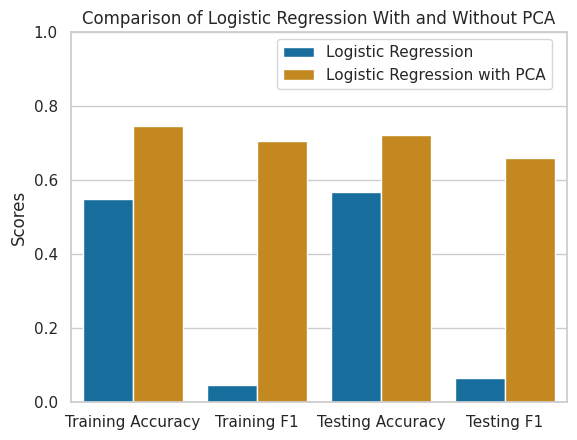

In [ ]:
labels = ['Training Accuracy', 'Training F1', 'Testing Accuracy', 'Testing F1']
logreg_results = [logreg_train_acc, logreg_train_f1, logreg_test_acc, logreg_test_f1]
pcalogreg_results = [pcalogreg_train_acc, pcalogreg_train_f1, pcalogreg_test_acc, pcalogreg_test_f1]
data = {'Method': ['Logistic Regression']*4 + ['Logistic Regression with PCA']*4, 
        'Score Type': labels*2,
        'Score': logreg_results + pcalogreg_results}

# Create grouped bar plot using Seaborn
sns.set(style="whitegrid")
ax = sns.barplot(x='Score Type', y='Score', hue='Method', data=data, palette="colorblind")
ax.set_ylabel('Scores')
ax.set_title('Comparison of Logistic Regression With and Without PCA')
ax.set_ylim([0, 1])
ax.legend(loc='upper left', bbox_to_anchor=(0.4, 1.002), ncol=1)

plt.show()

We observe that our logistic regression model without PCA is behaving like a majority class classifier by mostly predicting one class. Based on the difference between Accuracy and F1 scores, our analysis suggests that the Simple Logistic Regression is overfitting to the majority class. This highlights the importance of using a variety of evaluation metrics --- not just accuracy --- when assessing model performance. 

By utilizing F1-score, we can obtain a more complete and accurate picture of model performance. This is because F-1 Score is a measure of identifying both true positives and true negatives, while also minimizing false positives and false negatives. 

We conclude that overfitting is no longer a problem when using the Principal Component Analysis (PCA), which further highlights the importance of dimensionality reduction to deal with multicollinearity in the data.

In the chart below, we compare the MSE results of the linear regression, lasso regression, and Random Forest models.

Note that the Random Forest model with PCA has a higher MSE than the Random Forest model without PCA. This is not in line with our original intuition.

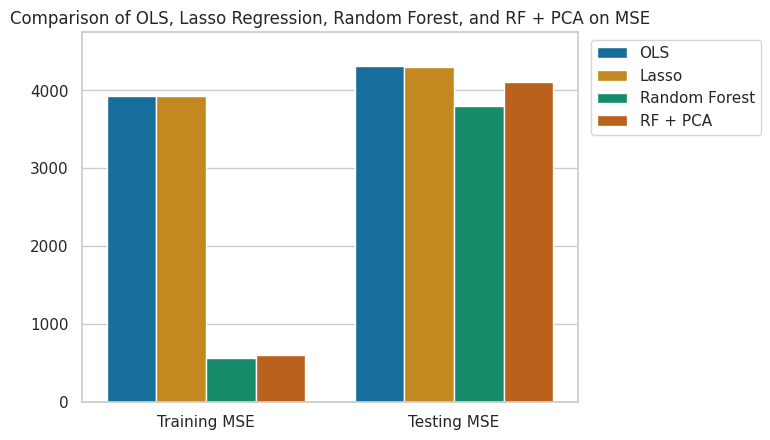

In [ ]:
labels = ['Training MSE', 'Testing MSE']
ols_results_mse = [ols_train_mse, ols_test_mse]
lasso_results_mse = [lasso_train_mse, lasso_test_mse]
rf_results_mse = [rf_train_mse, rf_test_mse]
pca_rf_results_mse = [pca_rf_train_mse, pca_rf_test_mse]
data = {'Method': ['OLS']*2 + ['Lasso']*2 + ['Random Forest']*2 + ['RF + PCA']*2, 
        'Score Type': labels*4,
        'Score': ols_results_mse + lasso_results_mse + rf_results_mse + pca_rf_results_mse}

# Create grouped bar plot using Seaborn
sns.set(style="whitegrid")
ax = sns.barplot(x='Score Type', y='Score', hue='Method', data=data, palette="colorblind")
ax.set_ylabel('')
ax.set_title('Comparison of OLS, Lasso Regression, Random Forest, and RF + PCA on MSE')
ax.set_ylim([0, max(ols_results_mse + lasso_results_mse + rf_results_mse + pca_rf_results_mse) * 1.1])
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), ncol=1)

plt.show()

In the chart below, we compare the R-Squared results of the linear regression, lasso regression, and Random Forest models.

Note that the Random Forest model with PCA has a slightly lower R-Squared value than the Random Forest model without PCA. This is not in line with our original intuition.

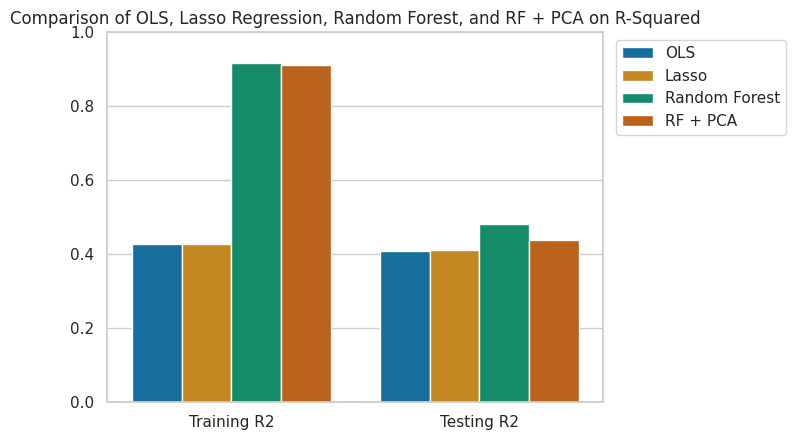

In [ ]:
labels = ['Training R2', 'Testing R2']
ols_results_r2 = [ols_train_r2, ols_test_r2]
lasso_results_r2 = [lasso_train_r2, lasso_test_r2]
rf_results_r2 = [rf_train_r2, rf_test_r2]
pca_rf_results_r2 = [pca_rf_train_r2, pca_rf_test_r2]
data = {'Method': ['OLS']*2 + ['Lasso']*2 + ['Random Forest']*2 + ['RF + PCA']*2, 
        'Score Type': labels*4,
        'Score': ols_results_r2 + lasso_results_r2 + rf_results_r2 + pca_rf_results_r2}

# Create grouped bar plot using Seaborn
sns.set(style="whitegrid")
ax = sns.barplot(x='Score Type', y='Score', hue='Method', data=data, palette="colorblind")
ax.set_ylabel('')
ax.set_title('Comparison of OLS, Lasso Regression, Random Forest, and RF + PCA on R-Squared')
ax.set_ylim([0, 1])
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), ncol=1)

plt.show()

# 5.) Challenges and Obstacles Faced

In our research, we came across various challenges and obstances that we needed to be overcome to be able to complete the project. 

When we began the project, we intended to use a dataset that gave Wage data for various zip codes, but, upon analyzing the wage data, we realized that quantity of features was very limited. We shifted our primary dataset to the [US Zip Code Module](https://uszipcode.readthedocs.io/index.html). This new dataset gave us significantly more information with each observation including aspects like male vs female totals, race/ethnicity totals, median household income, population, education levels, and more. The additional features improved our models and gave us more data to work with in our project.

Another issue we faced was caused by limitations with the Google Colab platform. With the free version of Google Colab, the assigned System RAM is ~12GB. If a user goes over that amount, Colab crashes and restarts. We ran into an issue where our datasets were too large to all exist in-memory at the same time. We had to engineer a "garbage collection" method which allowed us to keep the most important data we needed in-memory, and drop the unimportant data.

An additional challenge we can across was performing a thorough analysis of the zipcode and heart data. We realized that the heart data observations included various stratifications within the data based upon gender and race/ethnicity. This was a problem because we already had both gender and race accounted for from our zipcode data. As a result, we needed to clean the heart data so that we were only making predictions with heart disease mortality data that was derived from overall population segments, rather than stratisfied ones. This made our models more accurate, and allowed us to draw better conclusions.



# 6.) Potential Next Steps / Future Direction

We were able to gather some informative results based on our research and modeling. One area of discovery we thought was insightful was the principal components which had the largest impact on determining Heart Disease Mortality. From our study, the two most important features were "Quantity of Population from age 70 to 74" and "Median Household Income". Race and Gender features also existed as principal components. We belive that further work could be done to identify just how impactful these feature are for influencing Heart Disease (and other diseases) on various populations and whether actions could be taken to decrease heart conditions by focusing efforts in these specific areas (i.e. raising median household income).

In our research, we experimented with several different models which we used to predict Heart Disease Mortality Rates given our extensive list of features. We leveraged Logistic Regression, Linear Regression and Random Forest Models. Upon our analysis in Section 4 (Results and Visualization), we showed that solely using accuracy as an assessor of model effectiveness in inadequate. Going forward, we believe that other forms of modeling could be used to create mode effective models which could be used as better predictors to determine whether a certain zip code would suffer from high Heart Disease Mortality Rates.

Lastly, our team felt that further modeling and analysis could be performed on the 'stratification data' provided in the Heart dataset. In our modeling data, we focussed our observations to solely use 'overall' data for gender and race pertaining to Heart Disease Mortality. The dataset provided more observations with various stratification combinations which could be used for deeper analysis for how those qualities impact heart disease mortality rates.



# 7.) Conclusion

In conclusion, our team learned a lot from the process of:
1.   Determining a research topic of interest.
2.   Finding datasets which we believed would help us confirm or deny our hypothesis.
3.   Exploring the datasets to analyze what aspects mattered most to our research.
4.   Wrangling and cleaning the data in the datasets.
5.   Using the cleaned datasets to perform predictive modeling.
6.   Analyzing and reviewing the results of our modeling.

Thank you for taking the time to review our project, and we look forward to any future advancements in studies pertaining to this topic.

